# Wildfire risk potential

<b>Table of Contents</b>

- Overview
- Setup
    - Get authentication token
- Data layers
- Querying the data layers
    - Point query
    - Raster query
- References

## Overview

This Data Set provides calculation of wildfire hazard potential by the U.S. Department of Agriculture (USDA) and the United States Geological Survey (USGS) to inform evaluations of wildfire risk or prioritization of fuel management.

Let us get a practical understanding about this dataset and its usage through this tutorial.

## Setup

Before starting, you have to install IBM EI Geospatial python SDK i.e ibmpairs and other modules needed to run this sample, mentioned in the cell below.

<b>Note:</b> To run this notebook seamlessly, you have to first configure your Geospatial APIs' credentials in a file named `secrets.ini` in the below format:

```
[EI]
api.api_key = <Your Geospatial APIs API key>
api.tenant_id = <Your Geospatial APIs Tenant ID>
api.org_id = <Your Geospatial APIs Org ID>
```

Keep the secrets.ini file at an appropriate relative location of this notebook. For example, as specified in the config below.

```config.read('../../../../auth/secrets.ini')```

In [ ]:
%pip install ibmpairs
%pip install configparser
%pip install matplotlib
%pip install ipyplot

In [46]:
import ibmpairs.client as client
import ibmpairs.catalog as catalog
import ibmpairs.query as query
import pandas as pd
import configparser
import json
import numpy as np
from PIL import Image as PILImage
from IPython.display import Image, display
import matplotlib.pyplot as plt
import os
import ipyplot


Now, let us create a client object using the API_KEY, TENANT_ID (or CLIENT_ID) and ORG_ID to create an authenticated HTTP client Authentication token using 'ibmpairs.client' module, to use it in the subsequent steps.

### Get authentication token

In [42]:
config = configparser.RawConfigParser()
config.read('../../../../auth/secrets.ini')
# Best practice is not to include secrets in source code so we read
# an api key, tenant id and org id from a secrets.ini file.
# You could set the credentials in-line here but we don't
# recommend it for security reasons.

EI_API_KEY    = config.get('EI', 'api.api_key')
EI_TENANT_ID  = config.get('EI', 'api.tenant_id') 
EI_ORG_ID     = config.get('EI', 'api.org_id')  

EI_client_v3  = client.get_client(api_key   = EI_API_KEY,
                                    tenant_id = EI_TENANT_ID,
                                    org_id    = EI_ORG_ID,
                                    legacy    = False,
                                    version   = 3
                                   )

2025-01-24 10:05:27 - paw - INFO - The client authentication method is assumed to be OAuth2.
2025-01-24 10:05:27 - paw - INFO - Legacy Environment is False
2025-01-24 10:05:27 - paw - INFO - The authentication api key type is assumed to be IBM EIS, because the api key prefix 'PHX' is present.
2025-01-24 10:05:29 - paw - INFO - Authentication success.
2025-01-24 10:05:29 - paw - INFO - HOST: https://api.ibm.com/geospatial/run/na/core/v3


## Data layers

Let us start by querying the ibmpairs catalog to retrieve the Data Set ID and the Data Layers that form the Data Set.


In [43]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
search_df=catalog.search("Wildfire risk potential")
search_df[['dataset_id','data_layer_id','data_layer_name','data_layer_description_short',
           'data_layer_level','data_layer_type','data_layer_unit','data_set_name','data_set_description_short']]

,dataset_id,data_layer_id,data_layer_name,data_layer_description_short,data_layer_level,data_layer_type,data_layer_unit,data_set_name,data_set_description_short
0,284,51290,Wind Fire Potential Index,Wildfire Potential Index,15,Raster,,Wildfire risk potential,Calculation of wildfire hazard potential by the U.S. Department of Agriculture (USDA) and the United States Geological Survey (USGS) to inform evaluations of wildfire risk or prioritization of fuel management.



As seen above, the Wildfire risk potential Data Set of ID 284 has one Data Layer. This Data Layer defines wind fire potential index that estimates the fire danger. The Data Layer is identified by a unique Data Layer ID. To gain a better understanding of the Data Set and its geospatial and temporal coverage as well as other relevant metadata, we can make further queries to the ibmpairs catalog submodule as mentioned in the [tutorials](https://ibm.github.io/ibmpairs/tutorials/quickstart/quickstartcatalog.html).

## Querying the data layers
### Point query

Next, we shall perform a point query for different locations to observe wind fire potential index values.


In [44]:
query_result = query.submit(
    {
        "layers": [
            {
              "type": "raster",
              "id": "51290"
            }
        ],
        "spatial": {
            "type": "point",
            "coordinates": [
                46.823006, -119.871332,
                34.1458, -118.1771,
                34.169, -118.1716,
                34.7076, -117.716
            ]
        },
        "temporal": {
            "intervals": [
                {
                    "start": "2025-01-01T00:00:00Z",
                    "end": "2025-01-01T00:00:00Z"
                }
            ]
        }
    }, client=EI_client_v3)
# Convert the results to a dataframe
point_df = query_result.point_data_as_dataframe()
point_df['value'] = point_df['value'].apply(lambda x: '{:.6f}'.format(float(x)))
point_df['datetime'] = pd.to_datetime(point_df['timestamp'] , unit='ms', errors = 'coerce')
point_df['datetime'] = point_df['datetime'].dt.strftime('%Y-%m-%dT%H:%M:%SZ')
point_df = point_df.drop(columns=['timestamp'])
point_df

2025-01-24 10:06:43 - paw - INFO - TASK: submit STARTING.
2025-01-24 10:06:53 - paw - INFO - TASK: submit COMPLETED.


,layer_id,layer_name,dataset,longitude,latitude,value,datetime
0,51290,Wind Fire Potential Index,Wildfire risk potential,-118.177100,34.145800,42.000000,2025-01-01T00:00:00Z
1,51290,Wind Fire Potential Index,Wildfire risk potential,-118.171600,34.169000,42.000000,2025-01-01T00:00:00Z
2,51290,Wind Fire Potential Index,Wildfire risk potential,-117.716000,34.707600,252.000000,2025-01-01T00:00:00Z
3,51290,Wind Fire Potential Index,Wildfire risk potential,-119.871332,46.823006,1.000000,2025-01-01T00:00:00Z


We see above, wind fire potential index for various locations we queried for. For instance, the locations we queried for Data Layer `Wind Fire Potential Index` with Data Layer ID as `51290` has a value of `42.000000` for longitude of `-118.177100` and latitude of `34.145800`.


### Raster query

Next, we shall make a raster query for a square area and observe the outcome for wildfire risk potential.

In [18]:
wildfire_risk_result = query.submit_check_status_and_download(
    {
        "publish": True,
        "name": "Wildfire Risk Raster Query",
        "spatial": {
            "type": "square",
            "coordinates": [39.2971, -123.4731, 43.4193, -115.902] 
        },
        "temporal": {
            "intervals": [
                {
                    "start": "2025-01-01T00:00:00Z",
                    "end": "2025-01-01T00:00:00Z"
                }
            ]
        },
        "layers": [
            {
              "type": "raster",
              "id": "51290", 
            }
        ]
    }, client=EI_client_v3)

2025-01-24 09:19:54 - paw - INFO - TASK: submit_check_status_and_download STARTING.
2025-01-24 09:19:55 - paw - INFO - {"httpCode":"500","httpMessage":"Invalid-JWT-Validate","moreInformation":"JWT validation failed"}
2025-01-24 09:19:55 - paw - INFO - The authentication api key type is assumed to be IBM EIS, because the api key prefix 'PHX' is present; trying to refresh.
2025-01-24 09:19:55 - paw - INFO - Attempting to refresh authentication token.
2025-01-24 09:19:58 - paw - INFO - The token was successfully refreshed.
2025-01-24 09:19:59 - paw - INFO - The query was successfully submitted with the id: 1737676800_13799101.
2025-01-24 09:20:00 - paw - INFO - The query 1737676800_13799101 has the status Queued.
2025-01-24 09:20:31 - paw - INFO - The query 1737676800_13799101 has the status Succeeded.
2025-01-24 09:20:31 - paw - INFO - The query 1737676800_13799101 was successful after checking the status.
2025-01-24 09:21:02 - paw - INFO - The query 1737676800_13799101 has the status Su

The query takes a few seconds to complete and downloads the output as a zip file in the /download folder within the same location as this notebook. Now we shall display the resultant tiff using the following utility function.

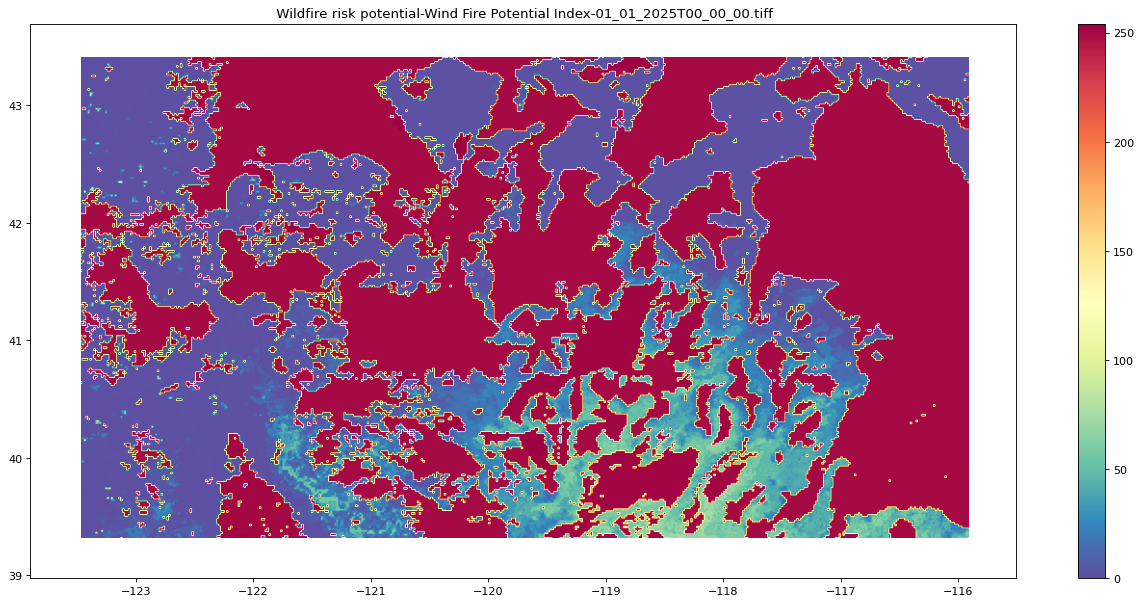

In [45]:
# Function to display the resulting Tiff(s).
wildfire_risk_file_list = wildfire_risk_result.list_files()
output_image_array = []
for file in wildfire_risk_file_list:
    if file.endswith('.tiff'): #display the raster images
        with open(file+'.json', 'r') as summary_file:
            fileparms = json.load(summary_file)
        boundingBox=fileparms["boundingBox"]
        pixelStatistics=fileparms["rasterStatistics"]
        myextent=[boundingBox["minLongitude"],
                  boundingBox["maxLongitude"],
                  boundingBox["minLatitude"],
                  boundingBox["maxLatitude" ] ]  
        array_wildfire_risk = np.array(PILImage.open(file))
        mask = (array_wildfire_risk == -9999)
        # Masked array to exclude NO Data points from plotting
        masked_array = np.ma.masked_array(array_wildfire_risk, mask)
        plt.figure(figsize = (20, 9), dpi=80) # Sets the size and resolution of the plot
        plt.imshow(masked_array,
                   cmap = 'Spectral_r', 
                   vmin=pixelStatistics["pixelMin"], 
                   vmax=pixelStatistics["pixelMax"],
                   extent = myextent) # Loads the raster data and sets the colormap
        plt.colorbar() # Adds the color bar
        plt.title(" "+os.path.basename(file)) 
        output_image_path = os.path.splitext(os.path.basename(file))[0] + ".png"
        output_image_array.append(output_image_path)
        # Save the figure
        plt.savefig(output_image_path, bbox_inches='tight')
        plt.close() 

for output_image in output_image_array:
    #display the raster images
    display(Image(output_image,width=800, height=400))    

In the image above, wind fire potential index shows the variations of values ranging from 0 - 250, that estimates the fire danger in the area of interest provided in the query. This helps in analysis of relative potential for high-intensity wildfire to build wildfire alerting system.

## References
https://www.usgs.gov/media/images/fire-potential-index-fpi-forecast

https://research.fs.usda.gov/firelab/products/dataandtools/datasets/wildfire-hazard-potential